## **Going Deeper 4. CutMix or Mixup Comparison Experiment**

* Augumentation에 의한 모델 성능 비교
  * No Augmentation
  * 기본 Augmentation
  * CutMix
  * Mixup
  * 기본 Augmentation + CutMix
  * 기본 Augmentation + Mixup 
* 각각의 Augmentation을 데이터에 적용하고 해당 데이터셋을 학습한 모델들의 정확도 성능 비교
* Augmentation 방법들의 영향도 분석

### Table of Contents

### 1. Import Libraries

### 2. Load Data

### 3. Apply Augmentation

### 4. Cutmix Augmentation

### 5. Mixup Augmentation

### 6. Building Dataset

### 7. Comparison Experiment
  * 7.1 Modeling
  * 7.2 Model Training
  * 7.3 Result

### 8. Improve Accuracy. 
  * 8.1 Albumentations
  * 8.2 Other Augmentation

### 9. Retrospection

****

### 1. Import Libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 2. Load Data

[**[tanford_dogs]**](https://www.tensorflow.org/datasets/catalog/stanford_dogs)
* 120개 견종의 이미지
* 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋

In [ ]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 데이터셋을 train, test로 분류하여 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

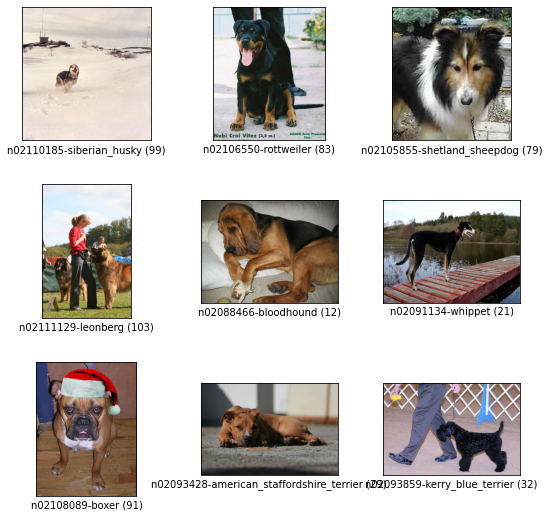

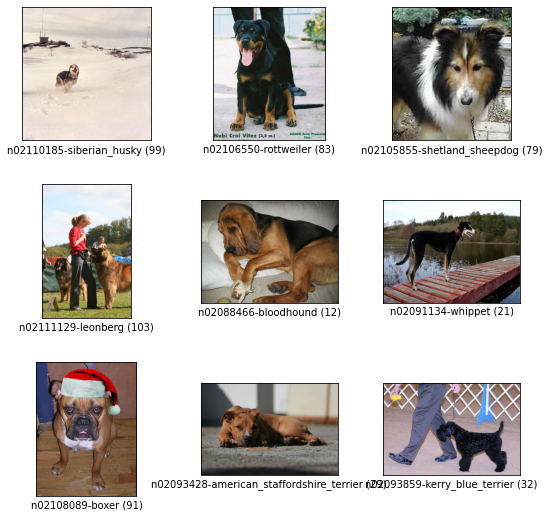

In [ ]:
# 다운로드한 데이터 확인
tfds.show_examples(ds_train, ds_info)

### 3. Apply Augmentation

* 텐서플로우 Random Augmentation API 사용하기

* `random_brightness()`
* `random_contrast()`
* `random_crop()`
* `random_flip_left_right()`
* `random_flip_up_down()`
* `random_hue()`
* `random_jpeg_quality()`
* `random_saturation()`

In [ ]:
# 입력받은 이미지를 0~1 사이의 float32로 normalize
# (224, 224) 사이즈로 resize
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
# "flip"의 경우 좌우 대칭
# "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    # is_test : 테스트 데이터셋인지 아닌지 확인
    # with_aug : augmentation의 적용여부 결정
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용 (normalize, resize)
        num_parallel_calls=2
    )
    if not is_test and with_aug:  # 테스트셋이 아니고 with_aug 적용하고자 함
        ds = ds.map(
            augment,       # augment 함수 적용 (flip, brightness)
            num_parallel_calls=2    # map(num_parallel_calls)를 사용하면 여러 개의 스레드로 나누어서 속도를 높여 처리 가능
        )
    ds = ds.batch(batch_size)
    if not is_test:  # 테스트셋이 아니라면 
        ds = ds.repeat()  #####
        ds = ds.shuffle(200)  #####
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  #####
    return ds

In [ ]:
ds_example_test = apply_normalize_on_dataset(ds_train, with_aug=False)

### 4. Cutmix Augmentation

* 아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타낸다.
* Mixup은 특정 비율로 픽셀별 값을 섞는 방식
* Cutout은 이미지를 잘라내는 방식
* CutMix는 일정 영역을 잘라서 붙여주는 방식

<p align="center"><img src = 'https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-2.max-800x600.png' height='400'></p>

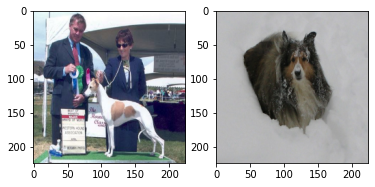

In [ ]:
# 배치 내의 이미지를 두 개 골라 섞어준다. 
# 데이터셋에서 이미지 2개를 가져온다. 
for i, (image, label) in enumerate(ds_example_test.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
# 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    # 바탕 이미지(a)의 사이즈
    image_size_x = image_a.shape[1]  # 가로
    image_size_y = image_a.shape[0]  # 세로
    
    # get center of box
    # tf.random.uniform([], 0, image_size_x) : 0 ~ image_size_x까지 숫자를 랜덤하게 뽑아 배열을 만든다.
    # 배열 부분이 []인 경우 범위 내에서 숫자 하나만 뽑아낸다.
    # tf.cast() : tf.random.uniform()에서 만들어진 배열을 tf.int32 타입으로 변환
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    # tf.random.uniform([], 0, 1) : 0~1 사이 랜덤한 숫자 하나를 뽑아낸다.
    # 1-tf.random.uniform([], 0, 1) : 1 보다는 작은 실수 
    # tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32) : 제곱근을 구한다. 위에서 나온 값보다 더 작은 값이 반환된다.
    # 위에서 구한 값을 image_size_x에 곱한 후 해당 값을 tf.int32 타입으로 변환
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(39, shape=(), dtype=int32) tf.Tensor(217, shape=(), dtype=int32)
y :  tf.Tensor(128, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


* 아래 코드를 그림으로 나타내면 이와 같이 나타낼 수 있다.
<p align='middle'><img src = 'https://media.vlpt.us/images/mjk3136/post/7390c6d6-fc62-45f8-9bae-e941b504ac88/%EC%9D%8C.png'></p>

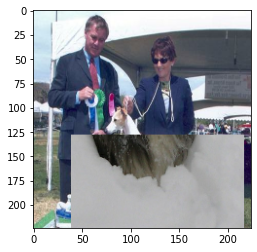

In [ ]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]  # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)  # middle = image_a 왼쪽 바깥 영역 + image_b 안쪽 영역 + image_a 오른쪽 바깥 영역
    top = image_a[0:y_min, :, :]  # image_a의 위쪽
    bottom = image_a[y_max:image_size_y, :, :]  # image_a의 아래쪽
    mixed_img = tf.concat([top, middle, bottom],axis=0)  # 결과적으로는 image_a가 바탕, image_b의 잘린 부분이 image_a에 삽입
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# 라벨 섞기
# CutMix에서는 면적에 비례해서 라벨을 섞어준다.
# 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더한다.
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)  # 삽입된 이미지의 면적
    total_area = image_size_x*image_size_y   # 바탕 이미지의 면적
    ratio = tf.cast(mixed_area/total_area, tf.float32)  # 바탕 이미지(a) 면적에서 삽입된 이미지(b)의 면적 비율

    if len(label_a.shape)==0:  # 라벨이 있다면
        label_a = tf.one_hot(label_a, num_classes)  # 라벨에 onehot encoding 적용
    if len(label_b.shape)==0:  # 라벨이 있다면
        label_b = tf.one_hot(label_b, num_classes)  # 라벨에 onehot encoding 적용
    mixed_label = (1-ratio)*label_a + ratio*label_b  # 라벨 또한 이미지의 면적 비율만큼 섞는다.
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.6594388, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [ ]:
# 위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size): # batch_size만큼 반복
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))  # mix_2_images() 적용 
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))  # mix_2_label() 적용

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 5. Mixup Augmentation

* Mixup은 간단하게 이미지와 라벨을 섞어준다. 
* 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있다.
* 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

<p align="center"><img src='https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-3.max-800x600.png' height='350'></p>

In [ ]:
num_classes = ds_info.features["label"].num_classes

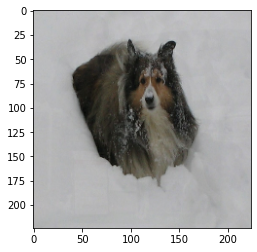

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02613854 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.97386146 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)  # 0~1 사이 랜덤한 숫자 하나를 뽑아낸다.
    
    if len(label_a.shape)==0:  # 라벨이 있다면 
        label_a = tf.one_hot(label_a, num_classes)  # 라벨에 onehot encoding 적용
    if len(label_b.shape)==0:  # 라벨이 있다면 
        label_b = tf.one_hot(label_b, num_classes)  # 라벨에 onehot encoding 적용
    mixed_image= (1-ratio)*image_a + ratio*image_b  # 이미지를 일정 비율로 섞는다.
    mixed_label = (1-ratio)*label_a + ratio*label_b  # 라벨도 동일하게 섞는다.
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
# 위에서 구현한 함수를 활용하여 "배치 단위"의 mixup() 함수를 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):  # barch_size만큼 반복한다.
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)  # 앞에서 구현한 함수 적용
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # tf.reshape(tensor, shape, name=None)
    # tf.stack() : 리스트 `mixed_imgs`, `mixed_labels`에 담긴 텐서들을 쌓아올린다.
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))  
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

# CutMix와 Mixup을 적용할 수 있도록 변경한 apply_normalize_on_dataset()
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # and 연산자 앞과 뒤 조건이 모두 True여야, if문이 실행된다.
    if not is_test and with_aug:  # 테스트셋이 아니고 with_aug를 적용하고자 한다. 
        ds = ds.map(
            augment  # augment 적용
        )
    ds = ds.batch(batch_size)  # Cutmix 적용하기 전 batch() 실행
    if not is_test and with_cutmix:  # 테스트셋이 아니고 with_cutmix를 적용하고자 한다.
        ds = ds.map(
            cutmix,  # cutmix 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # 테스트셋이 아니고 with_mixup을 적용하고자 한다.
        ds = ds.map(
            mixup,  # mixup 적용
            num_parallel_calls=2
        )
    else:  # 테스트셋이라면 onehot encoding 수행
        ds = ds.map(
            onehot, 
            num_parallel_calls=2
        )
    if not is_test:  # 테스트셋이 아니라면,
        ds = ds.repeat()  ######
        ds = ds.shuffle(200)  ######
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  ######
    return ds

* 이유는 잘 모르겠으나, 테스트세트에서는 suffle도 적용하지 않는다.
* 하지만 테스트셋에 onehot encoding을 수행한다.
* 이는 cutmix() 구현하면서 label의 mix 때문에 One-Hot 벡터 형태로 변환되어 
* 모델 학습 시 categorical_crossentropy()를 사용하기 때문에
* 테스트셋에도 동일하게 onehot encoding을 적용하는 것으로 판단된다. 

* CutMix나 Mixup을 사용하기 위해서는 `sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용해야 한다.
* `cutmix()`, `mixup()`을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다. 

### 6. Building Dataset 

**[총 6가지 데이터셋 구축]**
* No Augmentation
* 기본 Augmentation
* CutMix
* Mixup
* 기본 Augmentation + CutMix
* 기본 Augmentation + Mixup 

In [ ]:
# apply_normalize_on_dataset((ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 7. Comparison Experiment

* 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러온다.
* `include_top` 부분에서 fully connected layer를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다. 
* 우리가 사용하고자 하는 데이터셋이 이미지넷(ImageNet)과 서로 다른 클래스를 가지므로,
* 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 달라져야 한다.

### 7.1 Modeling

In [ ]:
# 1. Augmentation 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 2. 기본 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 3. CutMix만 적용한 데이터셋으로 학습시킬 ResNet
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 4. Mixup만 적용한 데이터셋으로 학습시킬 ResNet
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 6. 기본 Augmentation + Mixup를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

### 7.2 Model Training

* `cutmix()`, `mixup()`을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문에 `sparse_categorical_crossentropy` 대신 `categorical_crossentropy`를 사용해야 한다.

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2022)

# 1. Augmentation 적용하지 않은 데이터셋 학습 모델
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 2. 기본 Augmentation을 적용한 데이터셋 학습 모델
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 3. CutMix만 적용한 데이터셋 학습 모델
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 4. Mixup만 적용한 데이터셋 학습 모델
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋 학습 모델
resnet50_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 6. 기본 Augmentation + Mixup를 적용한 데이터셋 학습 모델
resnet50_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# 1. Augmentation 적용하지 않은 데이터셋 학습
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # Augmentation 적용하지 않은 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 121ms/step - loss: 2.1993 - accuracy: 0.4530 - top_k_categorical_accuracy: 0.7473 - val_loss: 3.9646 - val_accuracy: 0.1327 - val_top_k_categorical_accuracy: 0.3728
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 0.6907 - accuracy: 0.8133 - top_k_categorical_accuracy: 0.9725 - val_loss: 1.0761 - val_accuracy: 0.6763 - val_top_k_categorical_accuracy: 0.9348
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 0.1829 - accuracy: 0.9679 - top_k_categorical_accuracy: 0.9979 - val_loss: 0.9586 - val_accuracy: 0.7236 - val_top_k_categorical_accuracy: 0.9464
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0475 - accuracy: 0.9969 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9057 - val_accuracy: 0.7411 - val_top_k_categorical_accuracy: 0.9518
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0197 - accuracy: 0.9996 - to

In [ ]:
# 2. 기본 Augmentation을 적용한 데이터셋 학습
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # 기본 Augmentation을 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 2.2803 - accuracy: 0.4302 - top_k_categorical_accuracy: 0.7360 - val_loss: 2.7843 - val_accuracy: 0.2957 - val_top_k_categorical_accuracy: 0.6300
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.9365 - accuracy: 0.7354 - top_k_categorical_accuracy: 0.9498 - val_loss: 1.2424 - val_accuracy: 0.6364 - val_top_k_categorical_accuracy: 0.9153
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 0.5084 - accuracy: 0.8587 - top_k_categorical_accuracy: 0.9852 - val_loss: 1.1507 - val_accuracy: 0.6679 - val_top_k_categorical_accuracy: 0.9295
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 0.2568 - accuracy: 0.9399 - top_k_categorical_accuracy: 0.9968 - val_loss: 0.9939 - val_accuracy: 0.7153 - val_top_k_categorical_accuracy: 0.9454
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 0.1267 - accuracy: 0.9782 - top

In [ ]:
# 3. CutMix만 적용한 데이터셋 학습
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # CutMix만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 121ms/step - loss: 3.8188 - accuracy: 0.2135 - top_k_categorical_accuracy: 0.4507 - val_loss: 3.4359 - val_accuracy: 0.2028 - val_top_k_categorical_accuracy: 0.4620
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 2.9276 - accuracy: 0.4393 - top_k_categorical_accuracy: 0.7200 - val_loss: 1.4222 - val_accuracy: 0.6177 - val_top_k_categorical_accuracy: 0.9003
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 2.5923 - accuracy: 0.5419 - top_k_categorical_accuracy: 0.7872 - val_loss: 1.2726 - val_accuracy: 0.6400 - val_top_k_categorical_accuracy: 0.9101
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 2.4116 - accuracy: 0.6109 - top_k_categorical_accuracy: 0.8263 - val_loss: 1.1891 - val_accuracy: 0.6742 - val_top_k_categorical_accuracy: 0.9262
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 2.2412 - accuracy: 0.6611 - to

In [ ]:
# 4. Mixup만 적용한 데이터셋 학습
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 122ms/step - loss: 3.7406 - accuracy: 0.2415 - top_k_categorical_accuracy: 0.5027 - val_loss: 3.6930 - val_accuracy: 0.1581 - val_top_k_categorical_accuracy: 0.3996
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 2.8682 - accuracy: 0.4843 - top_k_categorical_accuracy: 0.7658 - val_loss: 1.8585 - val_accuracy: 0.5009 - val_top_k_categorical_accuracy: 0.8203
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 2.5837 - accuracy: 0.5779 - top_k_categorical_accuracy: 0.8249 - val_loss: 1.2494 - val_accuracy: 0.6435 - val_top_k_categorical_accuracy: 0.9173
Epoch 4/20
750/750 [==============================] - 97s 129ms/step - loss: 2.3968 - accuracy: 0.6521 - top_k_categorical_accuracy: 0.8627 - val_loss: 1.2998 - val_accuracy: 0.6376 - val_top_k_categorical_accuracy: 0.9057
Epoch 5/20
750/750 [==============================] - 97s 129ms/step - loss: 2.2406 - accuracy: 0.7142 - to

In [ ]:
# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋 학습
history_resnet50_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 122ms/step - loss: 3.8650 - accuracy: 0.2033 - top_k_categorical_accuracy: 0.4364 - val_loss: 3.7427 - val_accuracy: 0.1767 - val_top_k_categorical_accuracy: 0.4348
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 3.0381 - accuracy: 0.4072 - top_k_categorical_accuracy: 0.6923 - val_loss: 1.3603 - val_accuracy: 0.6212 - val_top_k_categorical_accuracy: 0.9023
Epoch 3/20
750/750 [==============================] - 93s 123ms/step - loss: 2.7244 - accuracy: 0.5001 - top_k_categorical_accuracy: 0.7648 - val_loss: 1.3199 - val_accuracy: 0.6315 - val_top_k_categorical_accuracy: 0.9040
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 2.5757 - accuracy: 0.5546 - top_k_categorical_accuracy: 0.7969 - val_loss: 1.2353 - val_accuracy: 0.6503 - val_top_k_categorical_accuracy: 0.9174
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 2.4330 - accuracy: 0.5950 - to

In [ ]:
# 6. 기본 Augmentation + Mixup를 적용한 데이터셋 학습
history_resnet50_aug_mixup = resnet50_aug_mixup.fit(
    ds_train_aug_mixup, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 122ms/step - loss: 1.8155 - accuracy: 0.8499 - top_k_categorical_accuracy: 0.9388 - val_loss: 1.2072 - val_accuracy: 0.6916 - val_top_k_categorical_accuracy: 0.9241
Epoch 2/20
750/750 [==============================] - 96s 129ms/step - loss: 1.8085 - accuracy: 0.8420 - top_k_categorical_accuracy: 0.9386 - val_loss: 1.2609 - val_accuracy: 0.6708 - val_top_k_categorical_accuracy: 0.9074
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 1.7646 - accuracy: 0.8505 - top_k_categorical_accuracy: 0.9414 - val_loss: 1.2446 - val_accuracy: 0.6818 - val_top_k_categorical_accuracy: 0.9167
Epoch 4/20
750/750 [==============================] - 92s 122ms/step - loss: 1.7477 - accuracy: 0.8572 - top_k_categorical_accuracy: 0.9432 - val_loss: 1.2889 - val_accuracy: 0.6750 - val_top_k_categorical_accuracy: 0.9011
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 1.7449 - accuracy: 0.8580 - top

### 7.3 Result

### 7.3.1 Visualization

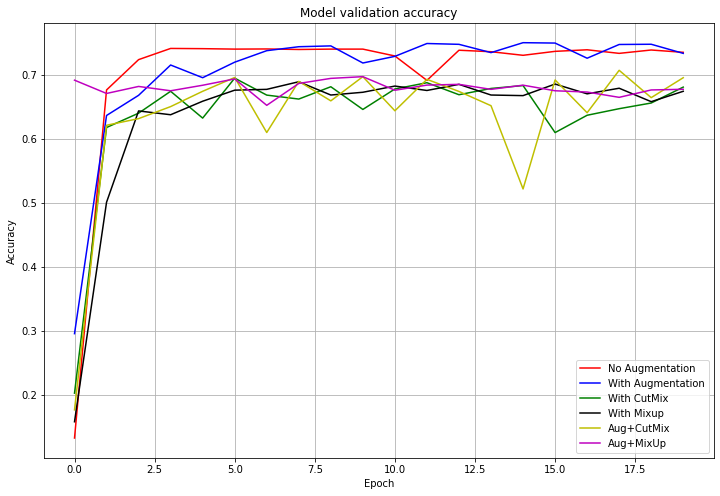

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup', 'Aug+CutMix', 'Aug+MixUp'], loc='lower right')
plt.grid(True)
plt.show()

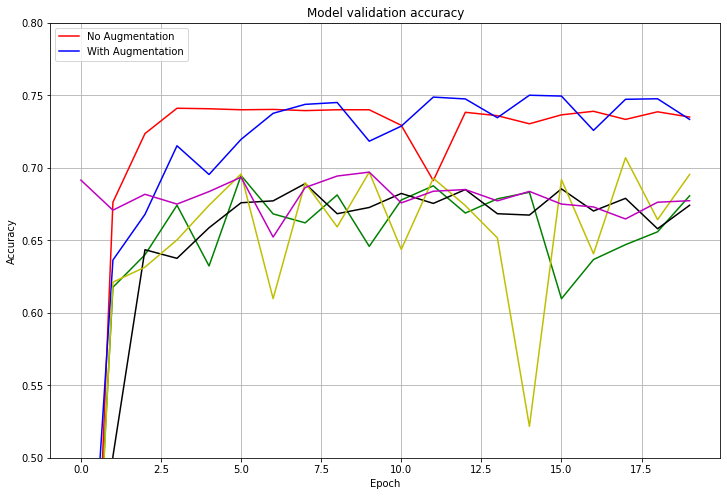

In [ ]:
# 조금 더 확대
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 7.3.2 Accuracy

In [ ]:
import pandas as pd

# val_accuracy
acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy'],
            'Aug+CutMix': history_resnet50_aug_cutmix.history['val_accuracy'],
            'Aug+MixUp': history_resnet50_aug_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
0,0.132696,0.295709,0.202775,0.158116,0.176656,0.691581
1,0.676306,0.636427,0.617654,0.500933,0.621152,0.670826
2,0.723647,0.667910,0.640042,0.643540,0.631530,0.681786
3,0.741138,0.715252,0.674207,0.637593,0.650303,0.675023
4,0.740788,0.695429,0.632346,0.658699,0.674207,0.683652
5,0.740089,0.719683,0.694730,0.675956,0.695779,0.693563
6,0.740322,0.737640,0.668260,0.677239,0.609841,0.652285
7,0.739506,0.743820,0.662080,0.689132,0.689716,0.686451
8,0.740089,0.745103,0.681320,0.668377,0.659282,0.694380
9,0.740089,0.718400,0.645872,0.672691,0.697062,0.697062


In [ ]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.701143,0.704454,0.637278,0.636398,0.634445,0.679944
std,0.134874,0.100633,0.105018,0.119488,0.115812,0.010654
min,0.132696,0.295709,0.202775,0.158116,0.176656,0.652285
25%,0.730148,0.717613,0.639226,0.658524,0.638439,0.675023
50%,0.737465,0.734025,0.665170,0.671467,0.661789,0.679571
75%,0.740089,0.747376,0.679163,0.677676,0.692164,0.685401
max,0.741138,0.750117,0.694730,0.689132,0.706973,0.697062


In [ ]:
# val_top5 accuracy
topkacc_data = {'No Augmentation': history_resnet50_no_aug.history['val_top_k_categorical_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_top_k_categorical_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_top_k_categorical_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_top_k_categorical_accuracy'],
            'Aug+CutMix': history_resnet50_aug_cutmix.history['val_top_k_categorical_accuracy'],
            'Aug+MixUp': history_resnet50_aug_mixup.history['val_top_k_categorical_accuracy']}
topkacc_data = pd.DataFrame(topkacc_data)
topkacc_data

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
0,0.372785,0.630014,0.461987,0.399604,0.434818,0.924091
1,0.934818,0.915345,0.900303,0.820312,0.902285,0.907416
2,0.946362,0.929454,0.910098,0.917327,0.904034,0.916744
3,0.951842,0.945429,0.926189,0.905667,0.917444,0.901119
4,0.951726,0.934002,0.901353,0.917327,0.921059,0.914062
5,0.951259,0.945895,0.929804,0.921292,0.930270,0.917094
6,0.951259,0.950327,0.914995,0.921992,0.881996,0.893773
7,0.951842,0.952192,0.916744,0.926306,0.927472,0.910798
8,0.950676,0.952192,0.920709,0.909981,0.911847,0.917211
9,0.951026,0.943330,0.903218,0.916395,0.929454,0.915928


In [ ]:
topkacc_data.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.918120,0.930066,0.885331,0.882439,0.884165,0.908361
std,0.128502,0.071274,0.100857,0.115705,0.109556,0.007904
min,0.372785,0.630014,0.461987,0.399604,0.434818,0.893773
25%,0.944934,0.944729,0.899166,0.905317,0.900216,0.901877
50%,0.947994,0.947295,0.908349,0.911905,0.914646,0.909107
75%,0.951084,0.952192,0.918698,0.916628,0.922837,0.914529
max,0.951842,0.954408,0.929804,0.926306,0.930270,0.924091


* Augmentation 적용 전과 후의 정확도에서 큰 차이를 보이지 않았다.
* 그러나 top-5 accuracy 확인 시 Augmentation을 적용한 것이 약 2%정도 높은 결과를 보였다. 
* Cutmix, Mixup을 적용했을 때 정확도가 더 낮아졌다.
* Cutmix, Mixup을 적용했을 때 이미지가 적절하게 적용되지 못한 데이터들이 생겨 정확도가 더 낮아진 것으로 판단된다. 
(ex.배경 이미지:강아지, 붙여진 이미지:사람얼굴or관련없는 배경)

### 8. Improve Accuracy

### 8.1 Albumentations

* Albumentations 라이브러리를 불러와 다른 augmentation을 적용해보았다.
* rotate, noise, flip을 사용해 80% 이상의 결과를 본 논문이 있어 동일한 augmentation 적용 시도
* 하지만, rotate를 적용할 경우 Cutmix의 좌표를 구하는 부분에서 error가 발생
* rotate를 제외한 noise, flip 적용

| - | No Augmentation | With Augmentation | With CutMix | With Mixup|	Aug+CutMix|	Aug+MixUp|
| :--: | :--: |	:--: | :--: | :--: | :--: | :--: |
mean|0.713468|0.013882|0.641645|0.637442|0.011999|0.013724|

* Augmentation을 적용한 경우 정확도가 1이 되지 않는다.
* 적용해준 Augmentation이 적절하지 못했던 것 같다.
* 이미지의 일반화가 더 잘 될 수 있는 조건을 찾아 적용해주면 더 나은 결과를 볼 수 있을 것 같다. 
* `Attachment1.OtherAugmentation.ipynb` 참조

### 8.2 Other Augmentation

* Gaussian Noise를 적용하는 함수를 만들어 적용해보았다.
* 이미지에 flip, brightness, Gaussian Noise. 총 3가지 augmentation을 적용했다.

| - | No Augmentation | With Augmentation | With CutMix | With Mixup|	Aug+CutMix|	Aug+MixUp|
| :--: | :--: |	:--: | :--: | :--: | :--: | :--: |
mean|0.712407|0.469181|0.636929|0.621496|0.385232|0.346240|

* 처음 Noise를 준 시도에서보다는 나은 결과를 보였다.
* 하지만, Augmentation을 주지 않은 데이터보다 낮은 정확도를 보였다.
* Gaussian Noise 함수 구현시 이미지를 랜덤하게 뽑아 적용하는 부분을 구현하지 못해 들어가는 이미지마다 전부 Noise가 적용되었다.
* 이 부분이 개선되면 더 나은 결과를 확인할 수 있을 것 같다.
* `Attacnment2.OtherAugmentation.ipynb` 참조

### 9. Retrospection

### 9.1 What was difficult

* Albumentations 라이브러리를 적용하기 위해서는 이미지를 Numpy배열로 바꿔 적용한 뒤, 다시 tensor 형태로 바꿔주어야 한다.
* 여러 가지의 시도들을 더 해보고 싶었으나, 원인을 알 수 없는 에러들이 발생해 시도해 보지 못한 것들이 많았다. 

### 9.2 What I found out

**[새로 알게된 점]**
* Augmentation을 적용한다고 해서 무조건 Accuracy가 좋아지는 것은 아니다.
* Data가 가지는 특성에 따라 일반화를 잘 이끌어낼 수 있는 Augmentation을 적용하는 것이 중요하다.
* 입력이미지를 0~1 사이로 normalize하는 이유
  * Data that goes into neural networks should usually be normalized in some way **to make it more amenable to processing by the network** (i.e. It is uncommon to feed raw pixels into a ConvNet.)
  * 해석 : 신경망으로 들어가는 데이터는 일반적으로 네트워크에서 **처리하기 쉽게 하기위해 어떤 방식으로든 정규화**가 되어야 한다. (raw pixel이 ConvNet에 전달하는 일은 드물다.)
  * https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C1/W4/ungraded_labs/C1_W4_Lab_1_image_generator_no_validation.ipynb


**[함수, 메서드 정리]**

1. `map()`
```
  map(map_func, num_parallel_calls=None, deterministic=None, name=None)
```
  * map_func를 데이터세트의 각 요소에 적용하고 변환된 요소를 포함하는 새 데이터세트를 입력에 나타난 것과 동일한 순서로 반환한다.

2. [test-time augmentation(TTA)](https://hwiyong.tistory.com/215)
  * 여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 방법

3. `tf.random.uniform()`
```python
tf.random.uniform(
    shape,
    minval=0,
    maxval=None,
    dtype=tf.dtypes.float32,
    seed=None,
    name=None
)
```
  * 원하는 형태의 랜덤 값을 가진 배열을 만든다.
  * `shape`에 배열의 형태가 들어간다.

4. `tf.cast()`
```python
tf.cast(x, dtype, name=None)
```
  * 배열의 dtype을 변경해 준다.
  * `x`에는 변경될 배열이 `dtype`에는 변경할 dtype이 들어간다.

5. `tf.one_hot()`
```python
tf.one_hot(
    indices,
    depth,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)
```
  * one-hot 인코딩은 one-of-k라고도 하며 0~k-1의 값을 가지는 정수 스칼라 값을 0 또는 1을 가지는 k차원(클래스수 =k)의 벡터로 변환한다.
  * 인덱스를 입력받아 one-hot인코딩 결과를 리턴한다.
  * `depth`의 지정한 위치(`indices`)에 지정한 값(`on_value`), 나머지 위치에 `off_value`값을 입력한다.
  * one_hot함수에서는 주의할 점은 입력받은 행렬보다 마지막에 한차원이 증가하게 된다
  * 증가된 차원을 적절히 핸들링해줘야 행렬곱등에서 문제가 발생하지 않는다.
  * 기본값으로 인덱스에 해당하는 위치에 1, 그렇지 않으면 0으로 표기한다.
  * `on_value`, `off_value`을 지정하는 경우 해당 위치에 `on_value`값, 그렇지 않으면 `off_value`값으로 표기한다.

6. `tf.stack()`
```python
tf.stack(values, axis=0, name='stack')
```
  * 여러 조각의 행렬을 합칠 때 사용
  * 순위 R 텐서 목록을 하나의 순위 (R+1) 텐서에 쌓는다.

7. `tf.data.Dataset.repeat()`
```python
repeat(count=None, name=None)
```
  * `count` 횟수만큼 데이터셋이 반복된다.
  * `count`가 -1 또는 값이 지정이 되지 않는다면 데이터셋이 무한 반복된다. 

8. `tf.data.Dataset.prefetch()`
```python
prefetch(buffer_size, name=None)
```
  * 데이터세트에서 요소를 미리 가져온다. 
  * 프리페치된 요소를 저장하기 위해 추가 메모리를 사용하는 대가로 대기 시간과 처리량을 향상시키는 경우가 많다.
  * 추가 참고 자료
    * [Tensorflow Core v2.8.0](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
    * [Tensorflow Core_tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko#%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B3%80%ED%99%98_%EB%B3%91%EB%A0%AC%ED%99%94)
    * [블로그 글_Data Prefetch](https://wh00300.tistory.com/90)

9. `tfds.load()`
```python
tfds.load(
    name: str,
    *,
    split: Optional[Tree[splits_lib.SplitArg]] = None,
    data_dir: Optional[str] = None,
    batch_size: tfds.typing.Dim = None,
    shuffle_files: bool = False,
    download: bool = True,
    as_supervised: bool = False,
    decoders: Optional[TreeDict[decode.partial_decode.DecoderArg]] = None,
    read_config: Optional[tfds.ReadConfig] = None,
    with_info: bool = False,
    builder_kwargs: Optional[Dict[str, Any]] = None,
    download_and_prepare_kwargs: Optional[Dict[str, Any]] = None,
    as_dataset_kwargs: Optional[Dict[str, Any]] = None,
    try_gcs: bool = False
)
```
  * `as_supervised: bool = False` : True이면 반환된 Dataset은 `builder.info.supervised_keys`에 따라 2-튜플 구조(입력, 레이블)를 갖는다. 기본값인 False인 경우 반환된 `tf.data.Dataset`에는 모든 feature가 포함된 dictionary가 있다. 

10. Top k accuracy
  * 정확도는 테스트셋에서 prediction label이 실제 데이터 label과 얼마나 같은지의 비율을 나타낸다.
  * Top-1 Accuracy : softmax의 out에서 제일 높은 수치를 가지는 값이 정답을 경우에 대한 지표. 흔히 가장 기본적인 Accuracy의 형태와 같다.
  * Top-5 Accuracy : softmax의 out에서 높은 5개의 class 중에 예측한 class가 존재하는 비율을 계산한 것
  * [Evaluating models using the Top N accuracy metrics](https://medium.com/nanonets/evaluating-models-using-the-top-n-accuracy-metrics-c0355b36f91b)

### 9.3 What I want to know more about

* 이미지를 Numpy배열로 불러올 시 더 다양한 Augmentation을 적용해 볼 수 있을 것 같았다.

### 9.4 Self-Resolution

* Going Deeper를 시작하면서 Code를 좀 더 자세히 살펴보기 위해 코드 주석을 달았다. 
* 이후에 진행할 프로젝트들도 동일하게 진행할 예정